In [1]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import numpy as np
# import random
# from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
# from scipy import optimize
# from PIL import Image
# from wordcloud import WordCloud, ImageColorGenerator
# from matplotlib.gridspec import GridSpec
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def sum_vibronics(spect_files, lambdarange, shift, norm_range=[0, -1], skip=[]):
    int_spect_sum = [0 for i in lambdarange]
    for i in spect_files:
        if i in skip: # skip a spectrum file
            continue
        spect = pd.read_csv(i, header=0, sep='\t\t')
        # spect.rename(columns={"Energy":"wavelength", "\tTotalSpectrum":"intensity"}, inplace=True)
        spect.rename(columns={"Energy":"wavelength", "IntensityFC":"intensity"}, inplace=True)
        spect = spect.reindex(index=spect.index[::-1]) # reorder data so wavelengths are increasing
        spect["shifted_wavelength"] = spect["wavelength"] * shift
        f = CubicSpline(spect["shifted_wavelength"], spect["intensity"])
        int_spect = f(lambdarange) # interpolate over the integer lambda values
        for n in range(len(int_spect_sum)):
            int_spect_sum[n] += int_spect[n]
    int_spect_sum = int_spect_sum - min(int_spect_sum)
    int_spect_sum = int_spect_sum / max(int_spect_sum[norm_range[0]:norm_range[1]])
    return int_spect_sum

def sum_vibronics_fromzip(spect_zip, lambdarange, shift, norm_range=[0, -1], skip=[]):
    int_spect_sum = [0 for i in lambdarange]
    with zipfile.ZipFile(spect_zip, 'r') as s:
        for i in s.namelist():
            if i in skip: # skip a spectrum file
                continue
            spect = pd.read_csv(s.open(i), header=0, sep='\t\t')
            # spect.rename(columns={"Energy":"wavelength", "\tTotalSpectrum":"intensity"}, inplace=True)
            spect.rename(columns={"Energy":"wavelength", "IntensityFC":"intensity"}, inplace=True)
            spect = spect.reindex(index=spect.index[::-1]) # reorder data so wavelengths are increasing
            spect["shifted_wavelength"] = spect["wavelength"] * shift
            f = CubicSpline(spect["shifted_wavelength"], spect["intensity"])
            int_spect = f(lambdarange) # interpolate over the integer lambda values
            for n in range(len(int_spect_sum)):
                int_spect_sum[n] += int_spect[n]
    int_spect_sum = int_spect_sum - min(int_spect_sum)
    int_spect_sum = int_spect_sum / max(int_spect_sum[norm_range[0]:norm_range[1]])
    return int_spect_sum

def mse(A, B):
    return np.square(np.subtract(A, B)).mean()

def lossfunct(bounds, ref_values, spect_files, lambdarange, skip=[]):
    calc_values = sum_vibronics(spect_files, lambdarange, bounds, skip)
    return mse(calc_values, ref_values)

def read_logfile(logfile,do_eV=False):
    """
    Reads a Gaussian .log file and extracts the f and either
    E(eV) or E(lambda) values of each excitation.
    Note: to apply lambda shift in nm by make_spectrum(), 
          eV should be set to False
    """
    parse = False
    with open(logfile) as inp:
        lmbda = np.array([])
        eV = np.array([])
        f = np.array([])
        for line in inp:
            if "Excitation energies and oscillator strengths:" in line:
                parse = True
            elif "******************************" in line:
                parse = False
            if parse == True and "Excited State" in line:
                line.strip()
                dat = line.split()
                lmbda = np.append(lmbda,[float(dat[6])])
                eV = np.append(eV,[float(dat[4])])
                f = np.append(f,[float(dat[8][2:])])
    if do_eV == False:
        return lmbda, f
    else:
        return eV, f

In [230]:
molecule = "Cu-phen_1"
functional = "CAM-B3LYP-D3" # CAM-B3LYP-D3 or B3LYP-D3
fitted_db_name = "_Cu_database_250nm.zip"
logfile = f"{molecule}_{functional}_def2SVP.log"
zipname = f"{molecule}_{functional}.zip"
l_min = 250
l_max = 700
lambdarange = np.arange(l_min,l_max+1)
# fls = [f"{molecule}\{functional}\{i}" for i in os.listdir(f"{molecule}\{functional}")]

In [231]:
expt_raw = pd.read_csv(f".\{molecule}.csv", names=["wavelength", "intensity"])
f = CubicSpline(expt_raw["wavelength"], expt_raw["intensity"]) # create an interpolation function
ipl_min = round(min(expt_raw["wavelength"]) + 1.)
ipl_max = round(max(expt_raw["wavelength"]) - 1.)
if ipl_min < l_min:
    ipl_min = l_min
if ipl_max > l_max:
    ipl_max = l_max
expt = f(np.arange(ipl_min,ipl_max)) # interpolate over the integer lambda values
expt = expt - min(expt)
expt = expt / max(expt)
lenexpt = len(expt)
expt = np.concatenate([np.zeros(abs(ipl_min-l_min)), expt, np.zeros(abs(ipl_max-l_max)+1)])

In [232]:
shift_vals = np.arange(80,131,2)/100
if functional == "CAM-B3LYP-D3":
    shift_vals = np.arange(100,131,2)/100
compr_min = ipl_min-l_min # cannot be negative, see cell above
compr_max = compr_min + lenexpt - 1
err_vals = []
for i in shift_vals:
    cvals = calc_values = sum_vibronics_fromzip(zipname, lambdarange, i, norm_range=[compr_min,compr_max])
    # cvals = calc_values = sum_vibronics(fls, lambdarange, i, norm_range=[compr_min,compr_max])
    err = mse(expt[compr_min:compr_max], cvals[compr_min:compr_max])
    print(f"shift: {i} --- mse: {err}")
    err_vals += [err]

best_shift = shift_vals[err_vals.index(min(err_vals))]
print(f"optimal shift: {best_shift}")

shift: 1.0 --- mse: 0.1310834901698503
shift: 1.02 --- mse: 0.1305812369448098
shift: 1.04 --- mse: 0.12989673564381482
shift: 1.06 --- mse: 0.12891194197240236
shift: 1.08 --- mse: 0.1270296715009725
shift: 1.1 --- mse: 0.12583810287212424
shift: 1.12 --- mse: 0.12464757916446181
shift: 1.14 --- mse: 0.12181495370238996
shift: 1.16 --- mse: 0.12089611650903123
shift: 1.18 --- mse: 0.11552732850477956
shift: 1.2 --- mse: 0.11607542554918378
shift: 1.22 --- mse: 0.11384321612061996
shift: 1.24 --- mse: 0.13062807398211915
shift: 1.26 --- mse: 0.13015249409063537
shift: 1.28 --- mse: 0.13132100696995477
shift: 1.3 --- mse: 0.13081839758539687
optimal shift: 1.22


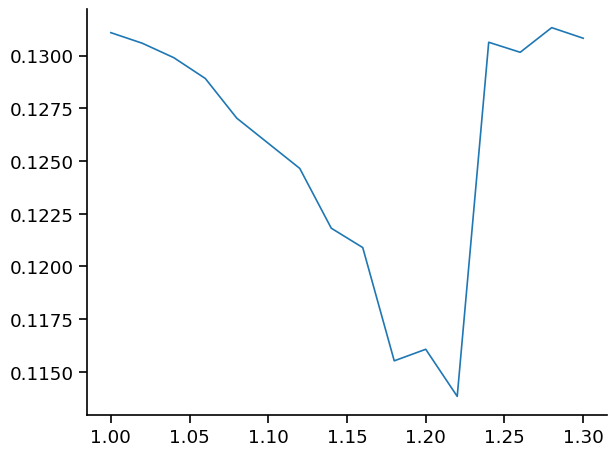

In [233]:
sns.reset_orig()
scale=1.2
sns.set_context("notebook", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                scale,'xtick.major.width': scale,'ytick.major.width': scale})

sns.lineplot(x=shift_vals, y=err_vals)

plt.tight_layout()
sns.despine()
plt.show()
plt.close()

In [234]:
# int_spect_sum = sum_vibronics(fls, lambdarange, best_shift, norm_range=[compr_min,compr_max])
int_spect_sum = sum_vibronics_fromzip(zipname, lambdarange, best_shift, norm_range=[compr_min,compr_max])
# int_spect_sum = sum_vibronics(fls, lambdarange, 1.18, norm_range=[compr_min,compr_max])
# int_spect_sum = sum_vibronics_fromzip(zipname, lambdarange, 0.98, norm_range=[compr_min,compr_max])

In [235]:
fitted_db = pd.read_csv(fitted_db_name).query("molecule == @molecule").query("functional == @functional").copy()
fitted_db.rename(columns={"Wavelength [nm]":"wavelength"}, inplace=True)
mn = lambdarange[compr_min]
mx = lambdarange[compr_max]
fitted_db = fitted_db.query("wavelength >= @mn").query("wavelength <= @mx").copy()
fitted_db["intensity"] = fitted_db["Intensity [a.u.]"] / fitted_db["Intensity [a.u.]"].max()
a_vert = float(fitted_db["shift_factor"].min()) # vertical shift used for the optimized vertical spectrum

In [236]:
if logfile != "":
    lmbda, f = read_logfile(logfile)
    sticks_full = pd.DataFrame({"wavelength": lmbda, "intensity_raw": f})
    # sticks_full["wavelength_shifted"] = sticks_full["wavelength"] * best_shift # use vibronic shift
    sticks_full["wavelength_shifted"] = sticks_full["wavelength"] * a_vert # use vertical shift
    sticks = sticks_full.query("wavelength_shifted > @lambdarange[0]").copy()
    sticks["intensity"] = sticks["intensity_raw"] / max(sticks["intensity_raw"])
    sticks["zeros"] = 0

In [237]:
# fig_text = r'${\alpha}_{vibr}$' + f" = {best_shift:.2f}" + "\n" + r'${\alpha}_{vert}$' + f" = {a_vert}"
fig_text_vibr = r'${\alpha}_{vibr}$' + f" = {best_shift:.2f}"
fig_text_vert = r'${\alpha}_{vert}$' + f" = {a_vert:.2f}"

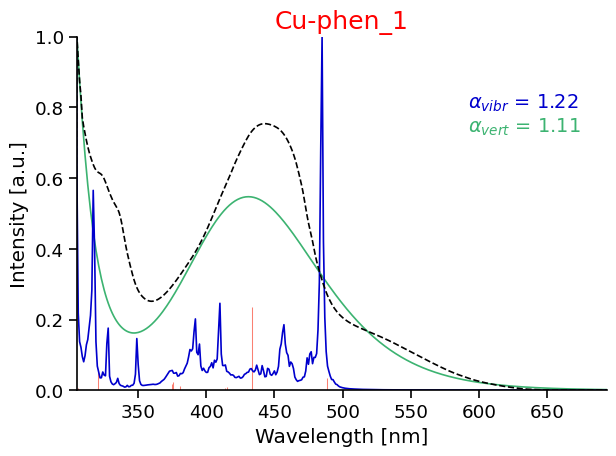

In [238]:
sns.reset_orig()
scale=1.2
sns.set_context("notebook", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                scale,'xtick.major.width': scale,'ytick.major.width': scale})

# plt.figure(figsize=(16, 10))

if logfile != "":
    plt.vlines(x=sticks["wavelength_shifted"], ymin=sticks["zeros"], ymax=sticks["intensity"], color="salmon", lw=0.75)

sns.lineplot(data=fitted_db, x="wavelength", y="intensity", color="mediumseagreen")
sns.lineplot(x=lambdarange, y=int_spect_sum, color="mediumblue")
sns.lineplot(x=lambdarange, y=expt, color="black", linestyle="--")

plt.xlim(lambdarange[compr_min], lambdarange[compr_max])
plt.ylim(0,1)
plt.title(f"{molecule}",c="red", fontdict = {'fontsize' : 18})
plt.xlabel("Wavelength [nm]")
plt.ylabel("Intensity [a.u.]")
# plt.figtext(0.75, 0.75, fig_text, fontsize=14, c="k")
plt.figtext(0.75, 0.75, fig_text_vibr, fontsize=14, c="mediumblue")
plt.figtext(0.75, 0.70, fig_text_vert, fontsize=14, c="mediumseagreen")
plt.tight_layout()
sns.despine()
plt.savefig(f"{molecule}_{functional}_vibr.png", dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()